In [1]:
import glob
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

In [2]:
# algorithms = ['gemm', 'igemm', 'ipgemm', 'fft', 'fftt', 'wino']
algorithms = [0, 1, 2, 4]
features = ['in_channels', 'out_channels', 'kernel_size', 'stride', 'groups', 'hw']

configs = pd.read_csv('./search_space/regnet_convs_unique.csv')
train_cfg_strs = []
test_cfg_strs = []
for i, row in configs.iterrows():
    cfg_str = '_'.join([str(int(row[k])) for k in features])
    if i < 4000:
        train_cfg_strs.append(cfg_str)
    else:
        test_cfg_strs.append(cfg_str)

In [3]:
def read_log(mode, algo):
    # df = pd.read_csv(sorted(glob.glob(f'./logs/{mode}/{algo}-*.csv'))[-1])
    if mode == 'energy':
        df = pd.read_csv(f'./logs/energy/{algo}-20230206.csv')
    elif mode == 'latency':
        df = pd.read_csv(f'./logs/energy/{algo}-20230206.csv')
    df['algo'] = algo
    df['params'] = df['out_channels'] * (np.square(df['kernel_size']) * df['in_channels'] / df['groups'] + 1)
    df['flops'] = np.square(df['hw'] // df['stride'])
    return df

energy_df = pd.concat([read_log('energy', algo) for algo in algorithms], ignore_index=True)
energy_df['test'] = [
    '_'.join([str(int(row[k])) for k in features]) in test_cfg_strs
    for i, row in energy_df.iterrows()
]
latency_df = pd.concat([read_log('latency', algo) for algo in algorithms], ignore_index=True)

print(f'Energy entries: {len(energy_df)} / Latency entries: {len(latency_df)} ')
# features = features + ['params', 'flops']

energy_df['power'] = energy_df['energy'] / energy_df['latency']
energy_df

Energy entries: 15237 / Latency entries: 15237 


,in_channels,out_channels,kernel_size,stride,groups,hw,gpu_id,algo,latency,energy,params,flops,test,power
0,1680,1680,3,1,10,7,4,0,0.000693,0.025806,2541840.0,49,False,37.238095
1,3000,3000,3,2,25,14,4,0,0.000411,0.015259,3243000.0,49,False,37.126521
2,208,52,1,1,1,14,4,0,0.000025,0.000900,10868.0,196,False,36.000000
3,792,792,3,2,11,7,4,0,0.000241,0.008933,514008.0,9,False,37.066390
4,448,448,3,2,4,56,4,0,0.000262,0.009709,452032.0,784,False,37.057252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15232,128,256,1,2,1,56,7,4,0.000022,0.000787,33024.0,784,True,35.772727
15233,4,16,1,1,1,112,7,4,0.000015,0.000526,80.0,12544,True,35.066667
15234,420,1680,1,1,1,14,7,4,0.000146,0.005433,707280.0,196,True,37.212329
15235,2088,2088,3,1,9,14,7,4,0.000906,0.033837,4361832.0,196,True,37.347682


In [4]:
def calc_rmse(y, pred):
    return np.sqrt(np.mean(np.square(y - pred)))

def calc_err(y, pred):
    return np.abs(y - pred) / y

def calc_acc(err, r):
    return sum(err <= r) / len(err) * 100

def evaluate(model, X, y, exp2=True):
    pred = model.predict(X)
    if exp2:
        y = np.exp2(y)
        pred = np.exp2(pred)
    err = calc_err(y, pred)
    results = [calc_acc(err, 0.05), calc_acc(err, 0.1), calc_acc(err, 0.15), calc_rmse(y, pred)]
    print("5%% : %2.2f%% | 10%% : %2.2f%% | 15%% : %2.2f%% | RMSE : %1.5f" % tuple(results))
    return results

In [5]:
def calc_grid_size(df, channel_thres, hw_thres, precomp):
    channel_scale = np.ceil(df['out_channels'] / channel_thres)
    if precomp:
        hw = df['hw'] - df['kernel_size'] + 1
    else:
        hw = df['hw']
    hw_scale = np.ceil(np.square(hw / df['stride']) / hw_thres)
    return (channel_scale * hw_scale).astype(np.int32)

def add_grid_size(df):
    df['grid_size_0'] = calc_grid_size(df, 32, 32, False)
    df['grid_size_1'] = calc_grid_size(df, 128, 64, False)
    # df['grid_size_2'] = calc_grid_size(df, 256, 64, False)
    # df['grid_size_3'] = calc_grid_size(df, 32, 32, True)
    # df['grid_size_4'] = calc_grid_size(df, 128, 64, True)

# grid_size_features = ['grid_size_0', 'grid_size_1', 'grid_size_2', 'grid_size_3', 'grid_size_4']
grid_size_features = ['grid_size_0', 'grid_size_1']
add_grid_size(energy_df)
add_grid_size(latency_df)
energy_df

,in_channels,out_channels,kernel_size,stride,groups,hw,gpu_id,algo,latency,energy,params,flops,test,power,grid_size_0,grid_size_1
0,1680,1680,3,1,10,7,4,0,0.000693,0.025806,2541840.0,49,False,37.238095,106,14
1,3000,3000,3,2,25,14,4,0,0.000411,0.015259,3243000.0,49,False,37.126521,188,24
2,208,52,1,1,1,14,4,0,0.000025,0.000900,10868.0,196,False,36.000000,14,4
3,792,792,3,2,11,7,4,0,0.000241,0.008933,514008.0,9,False,37.066390,25,7
4,448,448,3,2,4,56,4,0,0.000262,0.009709,452032.0,784,False,37.057252,350,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15232,128,256,1,2,1,56,7,4,0.000022,0.000787,33024.0,784,True,35.772727,200,26
15233,4,16,1,1,1,112,7,4,0.000015,0.000526,80.0,12544,True,35.066667,392,196
15234,420,1680,1,1,1,14,7,4,0.000146,0.005433,707280.0,196,True,37.212329,371,56
15235,2088,2088,3,1,9,14,7,4,0.000906,0.033837,4361832.0,196,True,37.347682,462,68


In [6]:
best_params = {'eta': 0.2, 'gamma': 0.001, 'n_estimators': 100, 'max_depth': 10, 'min_child_weight': 0}

# latency_input_features = features + ['algo', 'grid_size']
latency_input_features = features + ['algo']
# latency_input_features = features

train_X, train_y = latency_df[latency_input_features], latency_df['latency']
train_y = np.log2(train_y)

xgb_r = xgb.XGBRegressor(seed=2022, **best_params)
xgb_r.fit(train_X, train_y)
test_X, test_y = energy_df[latency_input_features], energy_df['latency']
test_y = np.log2(test_y)
print(f'Train set shape: {len(train_y)}')
acc_train = evaluate(xgb_r, train_X, train_y)
print(f'Test set shape: {len(test_y)}')
acc_test = evaluate(xgb_r, test_X, test_y)
latency_hat = xgb_r.predict(test_X)
latency_hat = np.exp2(latency_hat)
energy_df['latency_hat'] = latency_hat

# energy_df['latency_hat'] = 0
# for algo in range(len(algorithms)):
#     algo_filter = latency_df['algo'] == algo
#     algo_train_X = train_X[algo_filter]
#     algo_train_y = train_y[algo_filter]
#     cut = int(len(algo_train_y) * 0.8)
#     algo_val_X = algo_train_X.iloc[cut:, :]
#     algo_train_X = algo_train_X.iloc[:cut, :]
#     algo_val_y = algo_train_y.iloc[cut:]
#     algo_train_y = algo_train_y.iloc[:cut]
#     print(f'[{algorithms[algo]}] Train set shape: {len(algo_train_y)}')
#     xgb_r = xgb.XGBRegressor(seed=2022, n_estimators=100, **best_params)
#     xgb_r.fit(algo_train_X, algo_train_y)
#     acc_train = evaluate(xgb_r, algo_train_X, algo_train_y)
#     algo_filter = energy_df['algo'] == algo
#     algo_test_X = energy_df[algo_filter][latency_input_features]
#     algo_test_y = energy_df[algo_filter]['latency']
#     algo_test_y = np.log2(algo_test_y)
#     print(f'[{algorithms[algo]}] Val set shape: {len(algo_val_y)}')
#     acc_test = evaluate(xgb_r, algo_val_X, algo_val_y)
#     print(f'[{algorithms[algo]}] Test set shape: {len(algo_test_y)}')
#     acc_test = evaluate(xgb_r, algo_test_X, algo_test_y)
#     latency_hat = xgb_r.predict(algo_test_X)
#     latency_hat = np.exp2(latency_hat)
#     energy_df.loc[algo_filter, 'latency_hat'] = latency_hat

energy_df

Train set shape: 15237
5% : 15.90% | 10% : 27.52% | 15% : 36.81% | RMSE : 0.00041
Test set shape: 15237
5% : 15.90% | 10% : 27.52% | 15% : 36.81% | RMSE : 0.00041


,in_channels,out_channels,kernel_size,stride,groups,hw,gpu_id,algo,latency,energy,params,flops,test,power,grid_size_0,grid_size_1,latency_hat
0,1680,1680,3,1,10,7,4,0,0.000693,0.025806,2541840.0,49,False,37.238095,106,14,0.000714
1,3000,3000,3,2,25,14,4,0,0.000411,0.015259,3243000.0,49,False,37.126521,188,24,0.000393
2,208,52,1,1,1,14,4,0,0.000025,0.000900,10868.0,196,False,36.000000,14,4,0.000033
3,792,792,3,2,11,7,4,0,0.000241,0.008933,514008.0,9,False,37.066390,25,7,0.000232
4,448,448,3,2,4,56,4,0,0.000262,0.009709,452032.0,784,False,37.057252,350,52,0.000210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15232,128,256,1,2,1,56,7,4,0.000022,0.000787,33024.0,784,True,35.772727,200,26,0.000025
15233,4,16,1,1,1,112,7,4,0.000015,0.000526,80.0,12544,True,35.066667,392,196,0.000017
15234,420,1680,1,1,1,14,7,4,0.000146,0.005433,707280.0,196,True,37.212329,371,56,0.000081
15235,2088,2088,3,1,9,14,7,4,0.000906,0.033837,4361832.0,196,True,37.347682,462,68,0.000795


In [7]:
best_params = {'eta': 0.2, 'gamma': 0.001, 'n_estimators': 100, 'max_depth': 10, 'min_child_weight': 0}

all_features = features + ['algo']
print(all_features)

for target in ['latency', 'energy']:
    print(f'Target: {target}')
    X, y = energy_df[all_features], energy_df[target]
    y = np.log2(y)
    xgb_r = xgb.XGBRegressor(seed=2022, **best_params)
    xgb_r.fit(X, y)
    xgb_r.save_model(f'./predictor/models/V100_{target}.model')


['in_channels', 'out_channels', 'kernel_size', 'stride', 'groups', 'hw', 'algo']
Target: latency
Target: energy


In [8]:
accs = []
for all_features in [
    features + ['algo'],
    features + ['algo', 'latency'],
    # features + ['algo'] + grid_size_features,
    features + ['algo', 'latency'] + grid_size_features,
]:
    print(f'Features: {all_features}')
    X, y = energy_df[all_features], energy_df['energy']
    y = np.log2(y)
    train_X = X[energy_df['test'] == False]
    train_y = y[energy_df['test'] == False]
    print(f'Training set shape: {len(train_y)}')
    xgb_r = xgb.XGBRegressor(seed=2022, **best_params)
    xgb_r.fit(train_X, train_y)
    acc_train = evaluate(xgb_r, train_X, train_y)
    for algo in algorithms:
        # algo_filter = (energy_df['test'] == False) & (energy_df['algo'] == algo)
        # train_X = X[algo_filter]
        # train_y = y[algo_filter]
        # print(f'[{algorithms[algo]}] Training set shape: {len(train_y)}')
        # xgb_r = xgb.XGBRegressor(seed=2022, **best_params)
        # xgb_r.fit(train_X, train_y)
        algo_filter = (energy_df['test'] == True) & (energy_df['algo'] == algo)
        test_X = X[algo_filter]
        if 'latency' in all_features:
            test_X = test_X.copy()
            test_X['latency'] = energy_df[algo_filter]['latency_hat']
        test_y = y[algo_filter]
        print(f'[{algo}] Test set shape: {len(test_y)}')
        accs.append(evaluate(xgb_r, test_X, test_y))

accs = np.array(accs).reshape((3, len(algorithms), -1))

Features: ['in_channels', 'out_channels', 'kernel_size', 'stride', 'groups', 'hw', 'algo']
Training set shape: 12421
5% : 17.96% | 10% : 29.94% | 15% : 39.61% | RMSE : 0.01473
[0] Test set shape: 787
5% : 7.50% | 10% : 14.10% | 15% : 20.20% | RMSE : 0.01026
[1] Test set shape: 667
5% : 7.35% | 10% : 14.24% | 15% : 22.04% | RMSE : 0.01809
[2] Test set shape: 666
5% : 9.01% | 10% : 15.47% | 15% : 20.57% | RMSE : 0.01806
[4] Test set shape: 696
5% : 8.91% | 10% : 16.38% | 15% : 23.85% | RMSE : 0.01493
Features: ['in_channels', 'out_channels', 'kernel_size', 'stride', 'groups', 'hw', 'algo', 'latency']
Training set shape: 12421
5% : 99.86% | 10% : 99.97% | 15% : 99.99% | RMSE : 0.00016
[0] Test set shape: 787
5% : 16.01% | 10% : 31.00% | 15% : 42.82% | RMSE : 0.00708
[1] Test set shape: 667
5% : 14.84% | 10% : 26.24% | 15% : 35.83% | RMSE : 0.01459
[2] Test set shape: 666
5% : 14.11% | 10% : 27.33% | 15% : 37.09% | RMSE : 0.01396
[4] Test set shape: 696
5% : 19.11% | 10% : 30.03% | 15% : 4

Text(0.5, 1.0, 'Energy Predictor Accuracy on V100')

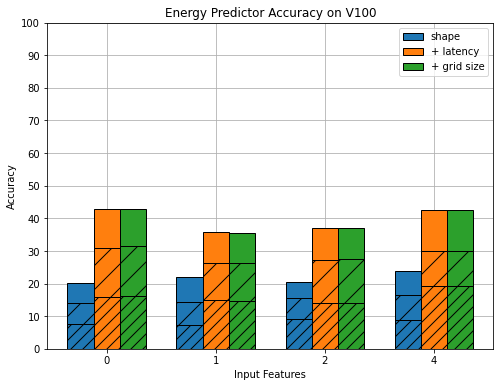

In [9]:
ind = np.arange(len(algorithms))

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

for i, feature_set in enumerate(['shape', '+ latency', '+ grid size']):
# for i, feature_set in enumerate(['shape', '+ grid size', '+ latency']):
    width = 0.24
    ind_shift = ind + (i - 3 // 2) * width
    ax.bar(ind_shift, accs[i, :, 2], hatch='', color=f'C{i}', edgecolor='black', width=width, label=feature_set)
    ax.bar(ind_shift, accs[i, :, 1], hatch='/', color=f'C{i}', edgecolor='black', width=width)
    ax.bar(ind_shift, accs[i, :, 0], hatch='//', color=f'C{i}', edgecolor='black', width=width)

ax.set_xticks(ind, algorithms)
ax.set_yticks(np.arange(11) * 10)
ax.grid()
ax.axis()
ax.set_axisbelow(True)
ax.set_xlabel('Input Features')
ax.set_ylabel('Accuracy')
ax.legend()
ax.set_title('Energy Predictor Accuracy on V100')

Text(0.5, 1.0, 'Energy Predictor RMSE on V100')

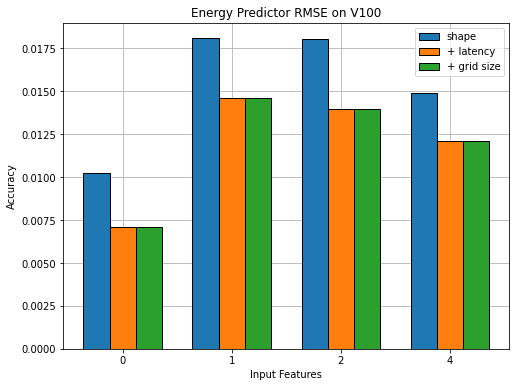

In [10]:
ind = np.arange(len(algorithms))

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

for i, feature_set in enumerate(['shape', '+ latency', '+ grid size']):
    width = 0.24
    ind_shift = ind + (i - 3 // 2) * width
    ax.bar(ind_shift, accs[i, :, 3], hatch='', color=f'C{i}', edgecolor='black', width=width, label=feature_set)

ax.set_xticks(ind, algorithms)
ax.grid()
ax.axis()
ax.set_axisbelow(True)
ax.set_xlabel('Input Features')
ax.set_ylabel('Accuracy')
ax.legend()
ax.set_title('Energy Predictor RMSE on V100')